# Demo of Build tools from SwiftPol

- Build a short linear co-polymer chain (PLGA)
- Create a small SwiftPol PLGA ensemble, assign partial charges to the chain, and inspect the chains in the system
- Solvate the PLGA ensemble with water, NaCl and 0.5% residual monomer

In [84]:
# Print SwiftPol Version
from swiftpol.__version__ import __version__
__version__

'0.1.0'

#### Import and inspect the monomers we will use in this build

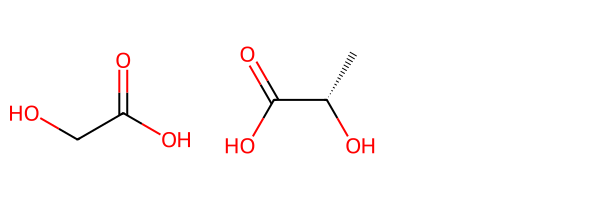

In [2]:
# Import monomers to build PLGA and visualise using RDkit
from rdkit import Chem
from rdkit import RDLogger 
RDLogger.DisableLog('rdApp.*')   
monomer_smiles = ['OC(=O)CO', 'C[C@@H](C(=O)[OH])O']
glycolic = Chem.MolFromSmiles(monomer_smiles[0])
lactate = Chem.MolFromSmiles(monomer_smiles[1])
Chem.Draw.MolsToGridImage([glycolic,lactate])

#### Build a short chain of alternating lactic and glycolic acid monomers. An iodine atom marks the point where monomers are joined

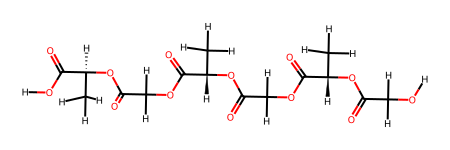

In [3]:
# Build a short linear chain using Swiftpol
from swiftpol import build
from rdkit.Chem import AllChem
monomer_list = ['OC(=O)COI', 'C[C@@H](C(=O)[OH])OI']
reaction = AllChem.ReactionFromSmarts('[C:1][O:2][H:3].[I:4][O:5][C:6]>>[C:1][O:2][C:6].[H:3][O:5][I:4]')
chain = build.build_polymer(sequence = 'ABABAB',
                            monomer_list= monomer_list,
                            reaction = reaction)
chain

#### Build an ensemble of PLGA chains with 50% Lactic acid and 50% glycolic acid

In [77]:
# Build a PLGA system
from rdkit.Chem import AllChem
polymer = build.polymer_system(monomer_list = ['OC(=O)COI', 'C[C@@H](C(=O)[OH])OI'], # List of iodinated monomers
                               reaction = AllChem.ReactionFromSmarts('[C:1][O:2][H:3].[I:4][O:5][C:6]>>[C:1][O:2][C:6].[H:3][O:5][I:4]'), # Condensation reaction SMARTS
                               length_target=10, # Target length of polymer
                               num_chains = 8, # Number of chains in ensemble
                               terminals='hydroxyl', # Terminal groups
                               blockiness_target=1.0, # Blockiness target
                               perc_A_target=50, # Percentage of A monomer
                               copolymer=True, # Copolymer or homopolymer
                               acceptance=5) # Acceptance criteria for polymer chain incorporation in ensemble (%)

System built!, size = 8


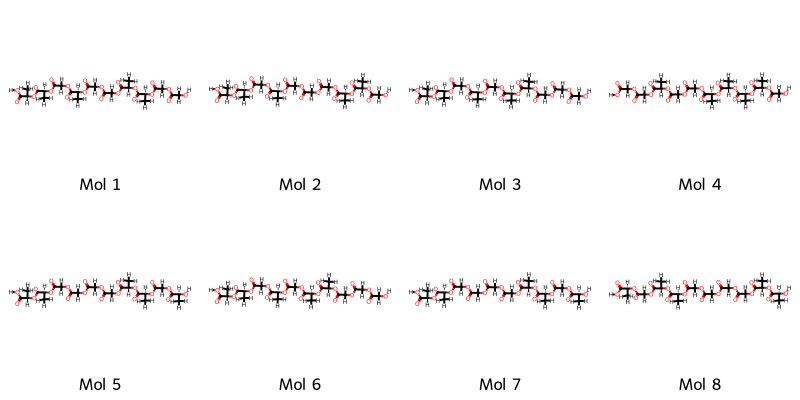

In [78]:
# Generate a grid image of the molecules
from rdkit.Chem import Draw
Draw.MolsToGridImage(
    polymer.chain_rdkit,
    molsPerRow=4,
    subImgSize=(200, 200),
    legends=[f"Mol {i+1}" for i in range(len(polymer.chain_rdkit))]
)

In [79]:
# Calculate the polydispersity index of the PLGA system
PDI = build.PDI(polymer.chain_rdkit)[0]
print('PDI = ', PDI)

PDI =  8.0


In [80]:
# Calculate the blockiness of the sequence
from swiftpol import build
mean_blockiness, G_block_length, L_block_length = build.blockiness_gen(sequence=polymer.sequence)
print("Average chain blockiness =", round(mean_blockiness,1))
print("G Block length =", round(G_block_length))
print("L Block length =", round(L_block_length))

Average chain blockiness = 1.0
G Block length = 2
L Block length = 2


In [81]:
# Charge the PLGA system using OpenFF NAGL 
polymer.charge_system('NAGL')

In [82]:
# Generate conformers and inspect first chain in 3D (requires nglview)
polymer.generate_conformers()
polymer.chains[0].visualize('nglview')

LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!


NGLWidget()

#### Optional - Use the calculate_box_components() function to calculate the input for the OpenFF packmol wrapper, and pack a solvated polymer box

In [83]:
# Use the OpenFF Packmol Wrapper to solvate the chains
# Example of using existing tools to prepare SwiftPol chains for Molecular Dynamics
from openff.units import unit
molecules, number_of_copies, topology, box_vectors, residual_monomer_actual = build.calculate_box_components(chains = polymer.chains, 
                                                                                                       monomers = polymer.monomers, 
                                                                                                       sequence = polymer.sequence, 
                                                                                                       salt_concentration= 1 * unit.mole/unit.litre,
                                                                                                       residual_monomer = 2.5,
                                                                                                       solvated=True)
print(f'residual monomer = {round(residual_monomer_actual,2)}%')
import openff.interchange.components._packmol as packmol_wrapper
solvated_top = packmol_wrapper.pack_box(molecules = molecules + polymer.chains,
                                        number_of_copies = number_of_copies+[1 for i in range(len(polymer.chains))],
                                        box_vectors = box_vectors,
                                        tolerance = 1*unit.angstrom)
solvated_top.visualize()

residual monomer = 2.39%


NGLWidget()